INTRODUCTION
"""
# Do Trader Actions Align with Market Sentiment?

## Problem Statement
We want to see if trader actions align with market sentiment.
Does the 'mood' of the market (Fear vs Greed) influence how traders use leverage, size their positions, and ultimately make or lose money?

## Hypothesis
- Traders use higher leverage during Greed and reduce risk during Fear.
- The most profitable traders might actually act *opposite* to sentiment — buying in Fear and selling in Greed.
"""

# IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime

sns.set(style="whitegrid")

#  LOAD DATA

In [6]:
trader_df = pd.read_csv("csv_files/historical_data.csv")
sentiment_df = pd.read_csv("csv_files/fear_greed_index.csv")

# Data Cleaning

In [11]:
trader_df['Date'] = pd.to_datetime(
    trader_df['Timestamp IST'], 
    format="%d-%m-%Y %H:%M",   
    errors='coerce'            
).dt.date

sentiment_df['date'] = pd.to_datetime(
    sentiment_df['date'], 
    errors='coerce'
).dt.date



# Standardize column names

In [12]:
trader_df.rename(columns={'Closed PnL': 'ClosedPnL', 'Size USD': 'SizeUSD', 'Size Tokens': 'SizeTokens'}, inplace=True)


# Merge Datasets

In [13]:
merged = pd.merge(trader_df, sentiment_df[['date','classification']], left_on='Date', right_on='date', how='inner')


# Feature Engineering

In [14]:
daily_summary = merged.groupby(['Date', 'classification']).agg({
    'ClosedPnL': ['mean', 'median', 'sum'],
    'SizeUSD': 'mean',
    'Execution Price': 'mean'
}).reset_index()
daily_summary.columns = ['Date','Sentiment','MeanPnL','MedianPnL','TotalPnL','AvgTradeSizeUSD','AvgPrice']


# Sentiment vs Behavior Analysis

C:\Users\hp\AppData\Local\Temp\ipykernel_6244\3789255994.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


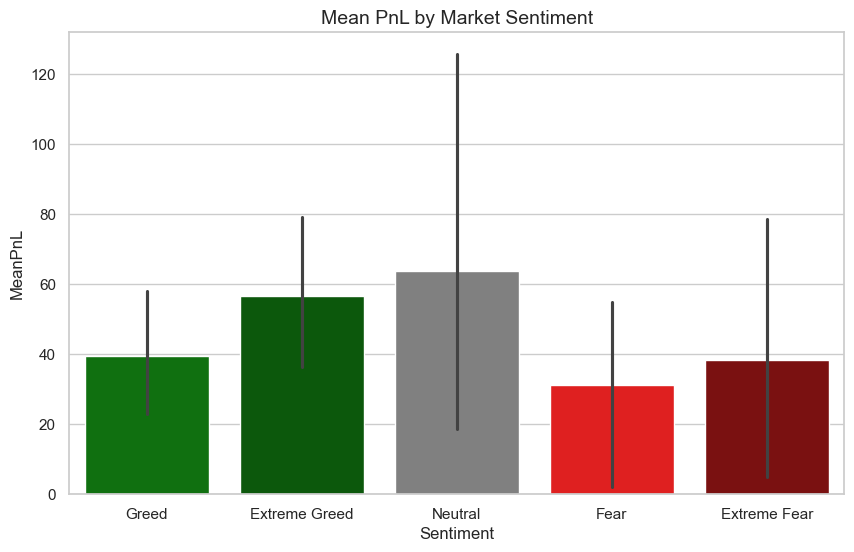

In [19]:
plt.figure(figsize=(10,6))

palette = {
    'Extreme Fear': '#8B0000',  # dark red
    'Fear': 'red',
    'Neutral': 'gray',
    'Greed': 'green',
    'Extreme Greed': '#006400'  # dark green
}

sns.barplot(
    x='Sentiment', 
    y='MeanPnL', 
    data=daily_summary, 
    palette=palette
)

plt.title("Mean PnL by Market Sentiment", fontsize=14)
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()


# Clustering Traders

In [21]:
from sklearn.preprocessing import StandardScaler

trader_features = merged.groupby('Account').agg({
    'ClosedPnL':'mean',
    'SizeUSD':'mean',
    'Execution Price':'mean'
}).reset_index()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features[['ClosedPnL','SizeUSD','Execution Price']])

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['Cluster'] = kmeans.fit_predict(X_scaled)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# Contrarian Analysis 

In [25]:
print(merged.columns)


Index(['Account', 'Coin', 'Execution Price', 'SizeTokens', 'SizeUSD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'ClosedPnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Date', 'date', 'classification'],
      dtype='object')


In [27]:
contrarian_df = (merged.groupby(['Account', 'classification']).agg({'ClosedPnL': 'mean'}).reset_index()
)

contrarian_df['Contrarian'] = contrarian_df.groupby('Account')['ClosedPnL'].transform(lambda x: x.idxmax())


# Advanced Visual: Heatmap


In [30]:
print(daily_summary.columns)


Index(['Date', 'Sentiment', 'MeanPnL', 'MedianPnL', 'TotalPnL',
       'AvgTradeSizeUSD', 'AvgPrice'],
      dtype='object')


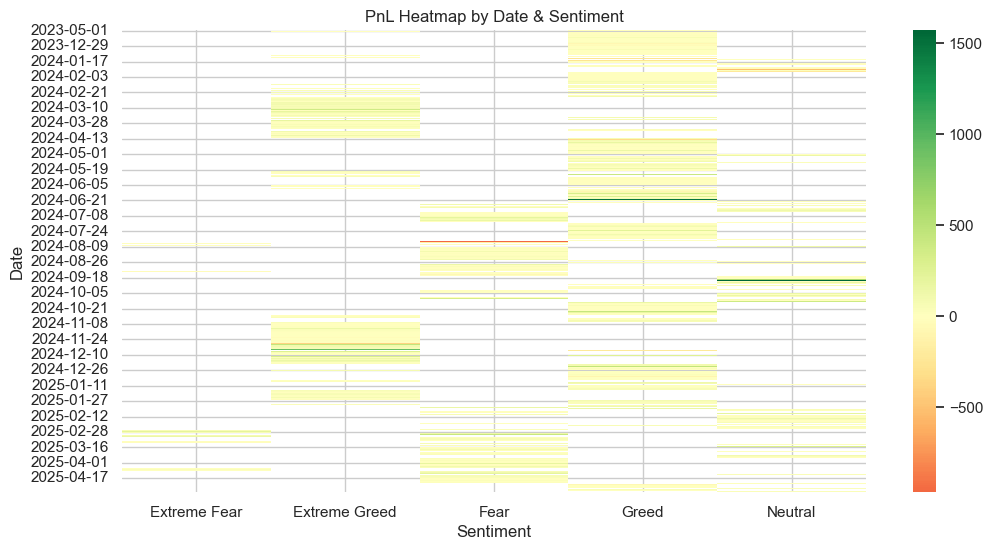

In [31]:
pivot_data = daily_summary.pivot(index='Date', columns='Sentiment', values='MeanPnL')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_data, cmap='RdYlGn', center=0)
plt.title("PnL Heatmap by Date & Sentiment")
plt.savefig("outputs/sentiment_trading_heatmap.png")
plt.show()

# Rolling 7-Day PnL vs Sentiment

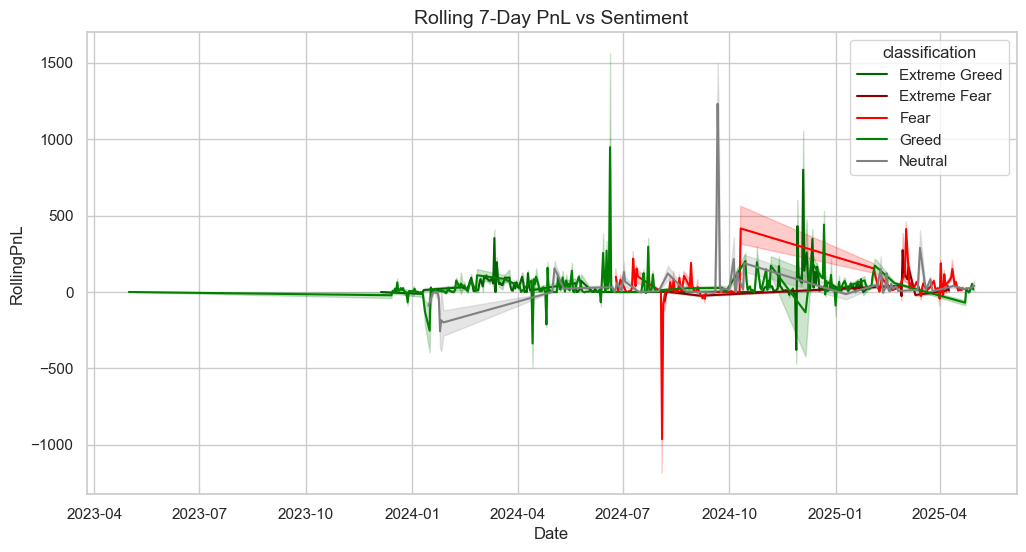

In [33]:
merged['RollingPnL'] = (
    merged.groupby('Account')['ClosedPnL']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

unique_classes = merged['classification'].unique()
palette = {
    'Extreme Fear': '#8B0000',  
    'Fear': 'red',
    'Neutral': 'gray',
    'Greed': 'green',
    'Extreme Greed': '#006400'  
}

missing_classes = [cls for cls in unique_classes if cls not in palette]
if missing_classes:
    auto_colors = sns.color_palette("hls", len(missing_classes))
    palette.update(dict(zip(missing_classes, auto_colors)))


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=merged,
    x='Date',
    y='RollingPnL',
    hue='classification',
    palette=palette
)
plt.title("Rolling 7-Day PnL vs Sentiment", fontsize=14)
plt.savefig("outputs/rolling_pnl_vs_sentiment.png")
plt.show()
